In [13]:
%load_ext autoreload
%autoreload 2

import math
import torch
import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from LightGCN import LightGCN
from RecommenderTrainer import *
from MovieDataProcessor import *
from sklearn.linear_model import LogisticRegression
from scipy.stats import spearmanr, pearsonr
from RecommenderCAV import *
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Set the directory for the dataset
data_path = "../hw1/ml-1m/ratings.dat"
movies_path = "../hw1/ml-1m/movies.dat"
users_path = "../hw1/ml-1m/users.dat"

# Load and preprocess data
processor = MovieDataProcessor(data_path, movies_path, users_path)
processor.load_data()

# Proj Score & Avg Rating Correlation

In [15]:


EMBEDDING_DIM = 64
NUM_LAYERS = 3
LEARNING_RATE = 0.01

# Define and train LightGCN model
model = LightGCN(
    num_users=processor.num_users,
    num_items=processor.num_items,
    embedding_dim=EMBEDDING_DIM,
    n_layers=NUM_LAYERS,
    user_feat_dim=processor.user_features.shape[1],
    item_feat_dim=processor.item_features.shape[1]
)

model.load_state_dict(torch.load("MovieLens_LightGCN.pth"))
model.eval()

model.get_final_embeddings(
    processor.adj_matrix, 
    processor.user_features, 
    processor.item_features
)


(tensor([[ 0.4722, -0.0956, -0.5477,  ...,  0.0583,  0.2068,  0.1151],
         [ 0.2117, -0.0743, -0.5976,  ..., -0.2803,  0.5928, -0.4712],
         [ 0.2030, -0.3411, -0.4637,  ...,  0.0288, -0.2773, -0.0402],
         ...,
         [-0.1608,  0.2833,  0.0050,  ..., -0.0653,  0.1121, -0.2304],
         [-0.0495,  0.5790, -0.3962,  ...,  0.0986,  0.1992, -0.3227],
         [ 0.0388,  0.2343, -0.4506,  ..., -0.0324,  0.6533,  0.0982]]),
 tensor([[ 0.9905,  1.2294, -1.1281,  ...,  0.2572,  0.3230, -0.7269],
         [ 0.4484,  0.4200, -0.4140,  ...,  0.0425,  0.4154, -0.1442],
         [ 0.4247,  0.4458, -1.3080,  ...,  0.6805,  0.6138, -0.2188],
         ...,
         [ 0.2781,  0.6842, -0.5125,  ..., -0.2715, -0.1277,  0.0765],
         [ 0.1317,  0.7159, -0.4697,  ..., -0.2097,  0.1726,  0.0516],
         [ 0.5281,  0.4520, -0.3941,  ..., -0.3035, -0.0975,  0.0582]]))

In [16]:
# Find the CAV for Comedy
from sklearn.decomposition import PCA
import importlib
import RecommenderCAV
importlib.reload(RecommenderCAV)
from RecommenderCAV import *
import seaborn as sns



example_concepts = ["Comedy", "Horror", "Thriller", "Drama"]

cavs = {}
conf_matrices = {}
for concept in example_concepts:
    CAV = RecommenderCAV(processor=processor, model=model)
    cavs[concept] = CAV.train_cav(concept)
    conf_matrices[concept] = CAV.conf_matrix
    
cav_vectors = np.array([cavs[concept] for concept in example_concepts])

pca = PCA(n_components=2)
cav_2d = pca.fit_transform(cav_vectors)

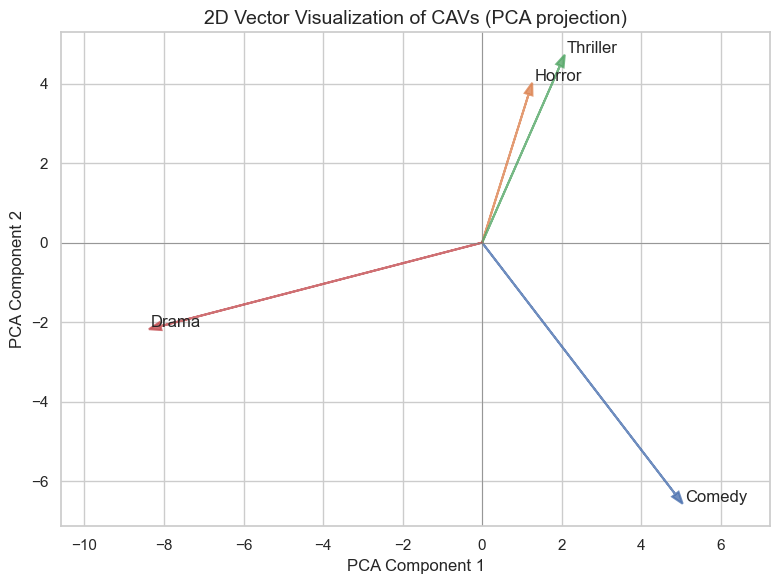

In [17]:
# Visualizing CAVS
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Plot origin
origin = np.array([0, 0])

# Draw arrows from origin to each cav vector
for i, name in enumerate(example_concepts):
    vec = cav_2d[i]
    plt.arrow(origin[0], origin[1], vec[0], vec[1],
              head_width=0.2, length_includes_head=True, color='C'+str(i), alpha=0.8, linewidth=1.5)
    plt.text(vec[0] + 0.05, vec[1] + 0.05, name, fontsize=12)

plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)

plt.title("2D Vector Visualization of CAVs (PCA projection)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

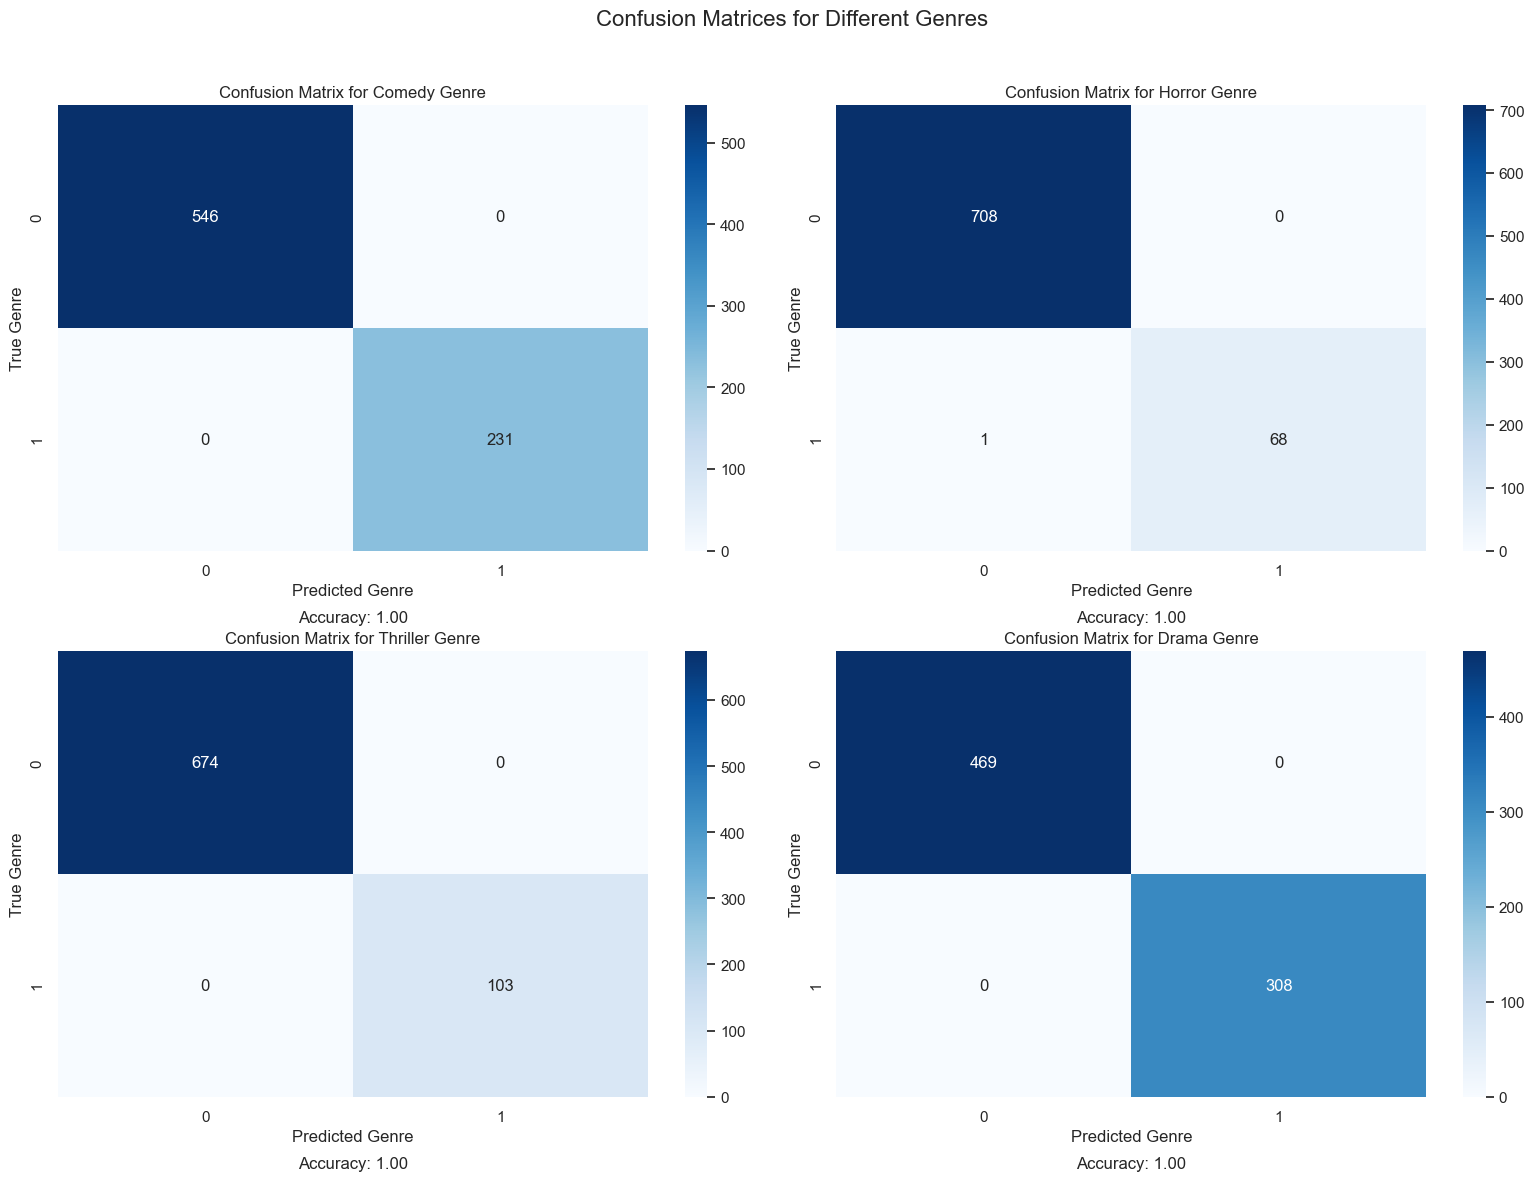

In [18]:
# Create a 2x2 subplot for all confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Plot each confusion matrix in its own subplot
for i, (genre, conf_matrix) in enumerate(conf_matrices.items()):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for {genre} Genre')
    axes[i].set_xlabel('Predicted Genre')
    axes[i].set_ylabel('True Genre')
    
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    axes[i].text(0.5, -0.15, f'Accuracy: {accuracy:.2f}', ha='center', va='center', transform=axes[i].transAxes)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Confusion Matrices for Different Genres', fontsize=16)
plt.show()

In [19]:
processor.item_features

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

In [20]:
processor.users

,user,gender,age,K-12 student,academic/educator,artist,clerical/admin,college/grad student,customer service,doctor/health care,...,other or not specified,programmer,retired,sales/marketing,scientist,self-employed,technician/engineer,tradesman/craftsman,unemployed,writer
0,0,1,1,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,0,56,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,2,0,25,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,3,0,45,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,0,25,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,6035,1,25,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
6036,6036,1,45,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6037,6037,1,56,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6038,6038,1,45,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [21]:
users_raw_data = pd.read_csv(users_path, sep="::",
                             names=["user", "gender", "age", "occupation", "zip"], 
                             engine="python")
print(users_raw_data.head())

user_to_occupation = {}

for idx, row in users_raw_data.iterrows():
    user_id = row['user']
    occupation = row['occupation']
    user_to_occupation[user_id] = processor.index_to_occ[occupation]

user_to_occupation

   user gender  age  occupation    zip
0     1      F    1          10  48067
1     2      M   56          16  70072
2     3      M   25          15  55117
3     4      M   45           7  02460
4     5      M   25          20  55455


{1: 'K-12 student',
 2: 'self-employed',
 3: 'scientist',
 4: 'executive/managerial',
 5: 'writer',
 6: 'homemaker',
 7: 'academic/educator',
 8: 'programmer',
 9: 'technician/engineer',
 10: 'academic/educator',
 11: 'academic/educator',
 12: 'programmer',
 13: 'academic/educator',
 14: 'other or not specified',
 15: 'executive/managerial',
 16: 'other or not specified',
 17: 'academic/educator',
 18: 'clerical/admin',
 19: 'K-12 student',
 20: 'sales/marketing',
 21: 'self-employed',
 22: 'scientist',
 23: 'other or not specified',
 24: 'executive/managerial',
 25: 'college/grad student',
 26: 'executive/managerial',
 27: 'lawyer',
 28: 'academic/educator',
 29: 'executive/managerial',
 30: 'executive/managerial',
 31: 'executive/managerial',
 32: 'other or not specified',
 33: 'clerical/admin',
 34: 'other or not specified',
 35: 'academic/educator',
 36: 'clerical/admin',
 37: 'homemaker',
 38: 'college/grad student',
 39: 'college/grad student',
 40: 'other or not specified',
 41:

In [22]:
all_genres = processor.genre_mapping.keys()

all_cavs = {}
correlations = {}
proj_scores = {}

for genre in all_genres:
    
    all_cavs[genre] = CAV.train_cav(genre)
    
    proj_scores[genre] = model.final_user_embedding @ all_cavs[genre]
    
    # Find user's average rating 
    genre_idx = processor.genre_mapping[genre]
    item_feature_matrix = processor.item_features.numpy()
    is_genre = item_feature_matrix[:, genre_idx] == 1
    
    user_ratings = {}
    for u, i, r in processor.data[['user', 'item', 'rating']].values.tolist():
        if is_genre[i]:
            user_ratings.setdefault(u, []).append(r)
            
    user_avg_ratings = {u:np.mean(r) for u, r in user_ratings.items()}
    user_avg_ratings = np.array([user_avg_ratings.get(i, 0) for i in range(processor.num_users)])
    
    valid_indices = user_avg_ratings > 0
    if np.sum(valid_indices)>10:
        correlation, p_value = pearsonr(
            proj_scores[genre][valid_indices], user_avg_ratings[valid_indices]
        )
        correlations[genre] = {
            'correlation': correlation,
            'p_value': p_value,
            'num_users': np.sum(valid_indices)
        }
    else:
        correlations[genre] = {
            'correlation': np.nan,
            'p_value': np.nan,
            'num_users': np.sum(valid_indices)
        }

sorted_results = sorted(
    correlations.items(),
    key = lambda x: abs(x[1]['correlation']) if not np.isnan(x[1]['correlation']) else 0,
    reverse=True
)



In [23]:
sorted_results[0]

('Musical',
 {'correlation': 0.12235968584716479,
  'p_value': 2.5348578167992456e-17,
  'num_users': 4754})

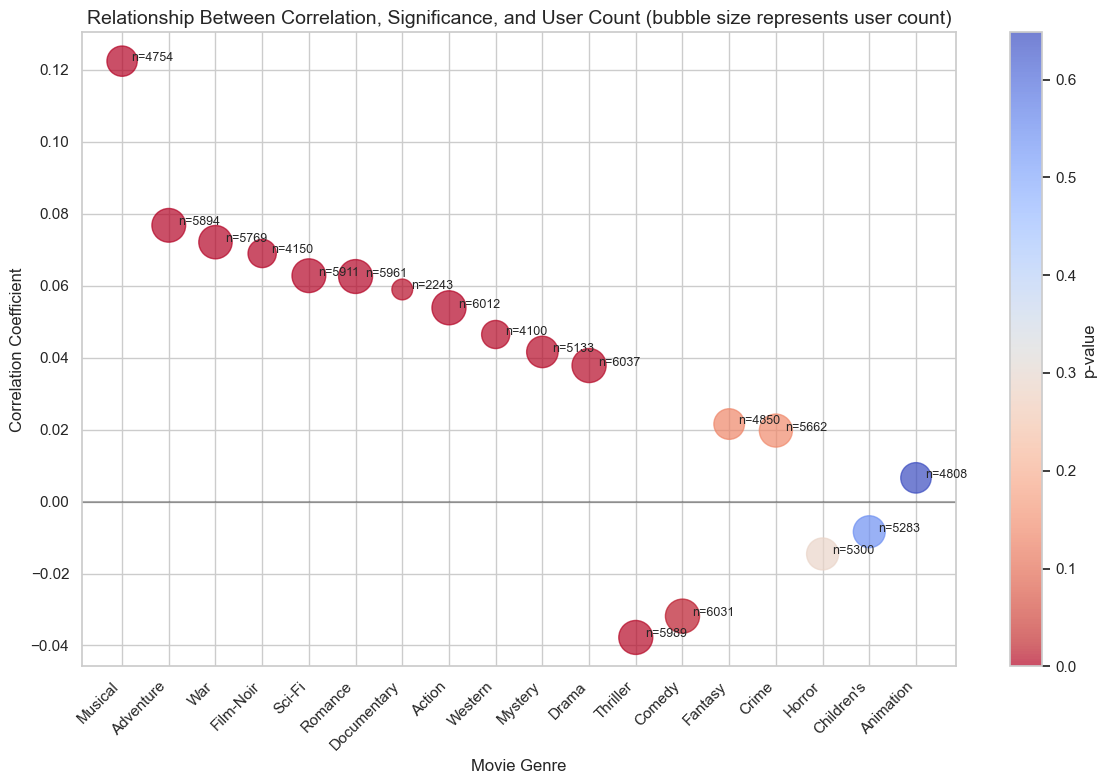

In [24]:
# Extract valid correlation data (filter out NaN values)
valid_concepts = []
correlation_values = []
p_values = []
user_counts = []

for concept, result in sorted_results:
    if not np.isnan(result['correlation']):
        valid_concepts.append(concept)
        correlation_values.append(result['correlation'])
        p_values.append(result['p_value'])
        user_counts.append(result['num_users'])
        
# Create bubble chart showing correlation, p-value, and user count
plt.figure(figsize=(12, 8))
scatter = plt.scatter(range(len(valid_concepts)), correlation_values, 
                     s=[count/10 for count in user_counts], # Bubble size determined by user count
                     c=p_values, cmap='coolwarm_r', # Color determined by p-value (smaller = redder)
                     alpha=0.7)

# Add sample size labels next to each bubble
for i, count in enumerate(user_counts):
    plt.text(i + 0.2, correlation_values[i], f'n={count}', fontsize=9)

plt.colorbar(scatter, label='p-value')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xticks(range(len(valid_concepts)), valid_concepts, rotation=45, ha='right')
plt.xlabel('Movie Genre', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.title('Relationship Between Correlation, Significance, and User Count (bubble size represents user count)', fontsize=14)
plt.tight_layout()
plt.show()

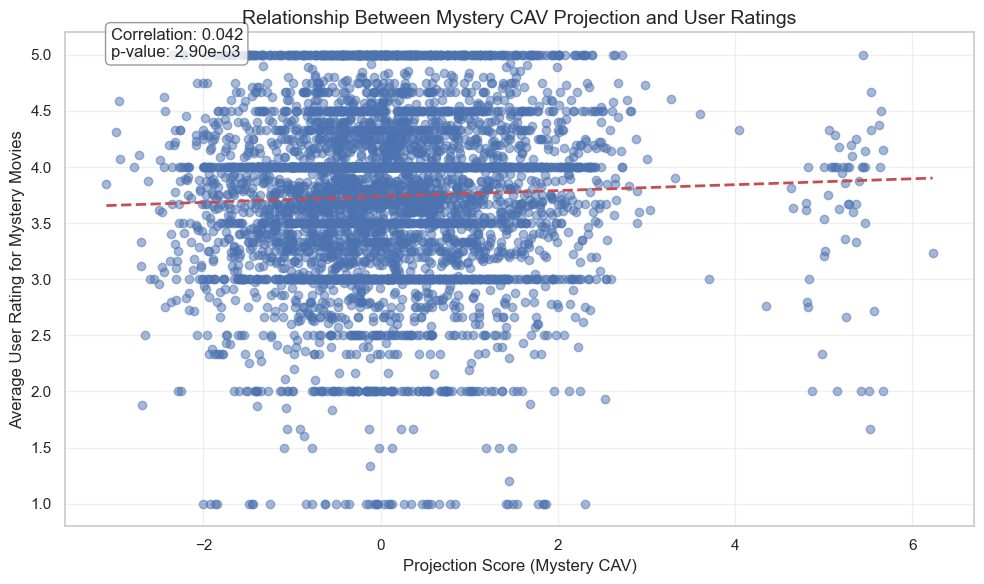

In [25]:
# Get the projection scores for Mystery genre
mystery_proj_scores = proj_scores['Mystery']

# Get the user average ratings for Mystery genre
genre_idx = processor.genre_mapping['Mystery']
item_feature_matrix = processor.item_features.numpy()
is_mystery = item_feature_matrix[:, genre_idx] == 1

user_ratings = {}
for u, i, r in processor.data[['user', 'item', 'rating']].values.tolist():
    if is_mystery[i]:
        user_ratings.setdefault(u, []).append(r)
        
user_avg_ratings = {u: np.mean(r) for u, r in user_ratings.items()}
user_avg_ratings_array = np.array([user_avg_ratings.get(i, 0) for i in range(processor.num_users)])

# Filter out users with no Mystery ratings
valid_indices = user_avg_ratings_array > 0
valid_proj_scores = mystery_proj_scores[valid_indices]
valid_avg_ratings = user_avg_ratings_array[valid_indices]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(valid_proj_scores, valid_avg_ratings, alpha=0.5)
plt.xlabel('Projection Score (Mystery CAV)', fontsize=12)
plt.ylabel('Average User Rating for Mystery Movies', fontsize=12)
plt.title('Relationship Between Mystery CAV Projection and User Ratings', fontsize=14)

# Add trend line
z = np.polyfit(valid_proj_scores, valid_avg_ratings, 1)
p = np.poly1d(z)
plt.plot(sorted(valid_proj_scores), p(sorted(valid_proj_scores)), 'r--', linewidth=2)

# Add correlation info
corr_value = correlations['Mystery']['correlation']
p_value = correlations['Mystery']['p_value']
plt.annotate(f'Correlation: {corr_value:.3f}\np-value: {p_value:.2e}', 
             xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [26]:
processor.index_to_occ

{0: 'other or not specified',
 1: 'academic/educator',
 2: 'artist',
 3: 'clerical/admin',
 4: 'college/grad student',
 5: 'customer service',
 6: 'doctor/health care',
 7: 'executive/managerial',
 8: 'farmer',
 9: 'homemaker',
 10: 'K-12 student',
 11: 'lawyer',
 12: 'programmer',
 13: 'retired',
 14: 'sales/marketing',
 15: 'scientist',
 16: 'self-employed',
 17: 'technician/engineer',
 18: 'tradesman/craftsman',
 19: 'unemployed',
 20: 'writer'}

In [27]:
# draw splcatter plot with color by occupat
valid_user_occupation = [user_to_occupation[i] for i in range(processor.num_users) if valid_indices[i]]
valid_user_occupation = np.array(valid_user_occupation)
print(valid_user_occupation.shape)
print(valid_proj_scores.shape)
print(valid_avg_ratings.shape)

#get top 10 most common occupations
scatter_plot_df = pd.DataFrame({'proj_score': valid_proj_scores, 
                                'avg_rating': valid_avg_ratings, 
                                'occupation': valid_user_occupation})

print(scatter_plot_df.head())


(5133,)
torch.Size([5133])
(5133,)
   proj_score  avg_rating            occupation
0   -0.347561    3.333333          K-12 student
1   -0.063401    3.000000         self-employed
2   -1.612432    3.125000  executive/managerial
3   -0.132806    4.000000             homemaker
4   -1.709399    3.500000     academic/educator


In [28]:
top5_occupations = scatter_plot_df['occupation'].value_counts().head(5).index.tolist()
scatter_plot_df = scatter_plot_df[scatter_plot_df['occupation'].isin(top5_occupations)]


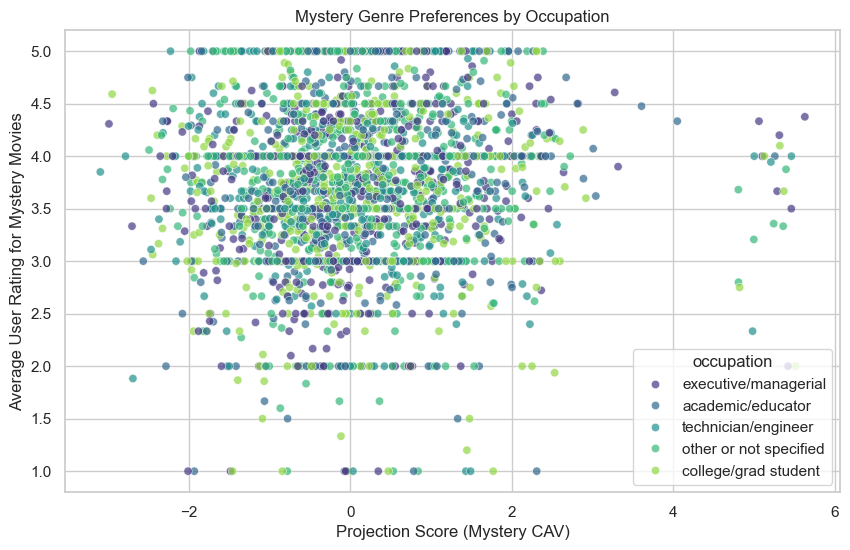

In [29]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=scatter_plot_df, x='proj_score', y='avg_rating', hue='occupation', palette='viridis', alpha=0.7)
plt.xlabel('Projection Score (Mystery CAV)')
plt.ylabel('Average User Rating for Mystery Movies') 
plt.title('Mystery Genre Preferences by Occupation')
plt.show()


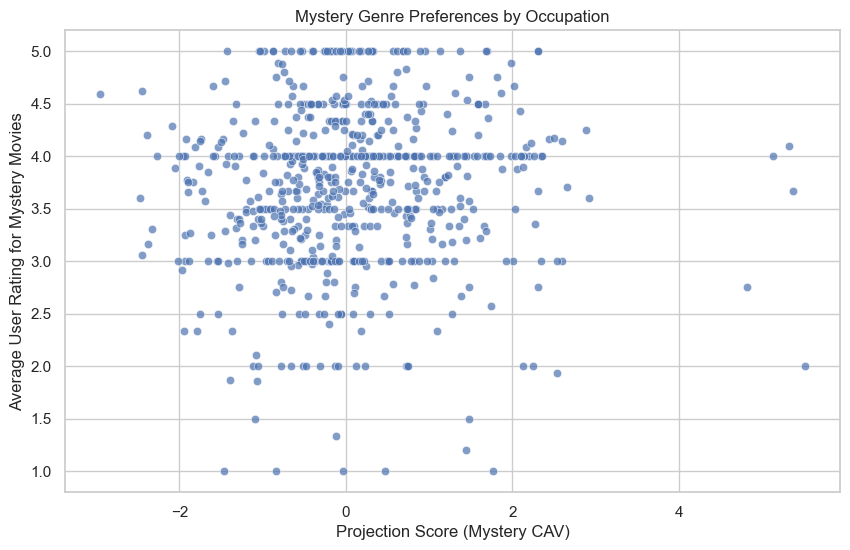

In [30]:
# plot college/grad student alone

plt.figure(figsize=(10, 6))
sns.scatterplot(data=scatter_plot_df[scatter_plot_df['occupation'] == 'college/grad student'], x='proj_score', y='avg_rating', alpha=0.7)
plt.xlabel('Projection Score (Mystery CAV)')
plt.ylabel('Average User Rating for Mystery Movies') 
plt.title('Mystery Genre Preferences by Occupation')
plt.show()



# Model with features and model without features

Now we load the reduced model trained using only user-item interaction matrix

In [31]:
reduced_model = LightGCN(
    num_users=processor.num_users,
    num_items=processor.num_items,
    embedding_dim=EMBEDDING_DIM,
    n_layers=NUM_LAYERS,
    user_feat_dim=processor.user_features.shape[1],
    item_feat_dim=processor.item_features.shape[1])

reduced_model.load_state_dict(torch.load("MovieLens_LightGCN_No_Features.pth"))

reduced_model.eval()

reduced_model.get_final_embeddings(
    processor.adj_matrix, 
    torch.zeros_like(processor.user_features),
    torch.zeros_like(processor.item_features)
)


(tensor([[ 0.0691, -0.4925, -0.3526,  ...,  0.2228,  0.2185, -0.1320],
         [ 0.1191, -0.5196, -0.4939,  ...,  0.4252,  0.7403, -0.0860],
         [-0.1591, -0.4217, -0.4270,  ...,  0.3996,  0.3673, -0.1229],
         ...,
         [-0.0855, -0.4984, -0.3031,  ...,  0.4070,  0.6053, -0.2461],
         [-0.2023, -0.6159, -0.1473,  ...,  0.3448,  0.4371, -0.2916],
         [-0.0343, -0.3774, -0.6306,  ...,  0.6006,  1.0696, -0.4056]]),
 tensor([[ 7.4631e-02, -1.8635e+00, -1.6413e+00,  ...,  2.4041e+00,
           2.0681e+00, -6.0676e-01],
         [ 9.3038e-02, -4.4158e-01, -1.0900e+00,  ...,  8.9412e-01,
           1.4608e+00, -1.9877e-01],
         [-1.5014e-01, -3.4473e-01, -9.7417e-01,  ...,  1.2214e+00,
           1.1114e+00, -1.7327e-01],
         ...,
         [ 7.7193e-02, -1.8148e-03, -2.9310e-01,  ...,  6.8131e-01,
           4.4220e-01, -1.7576e-01],
         [-1.6030e-02, -3.3615e-01, -2.4631e-01,  ...,  6.1939e-01,
           5.5616e-01, -3.7800e-01],
         [-2.6116e-

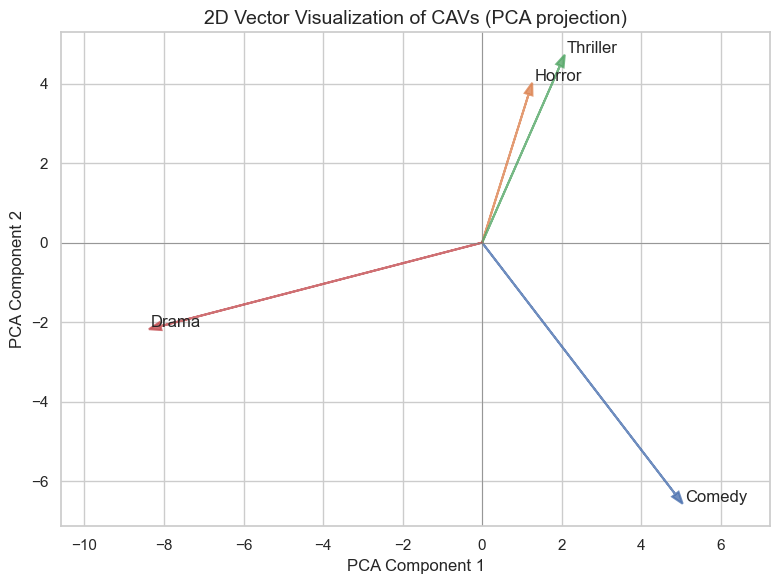

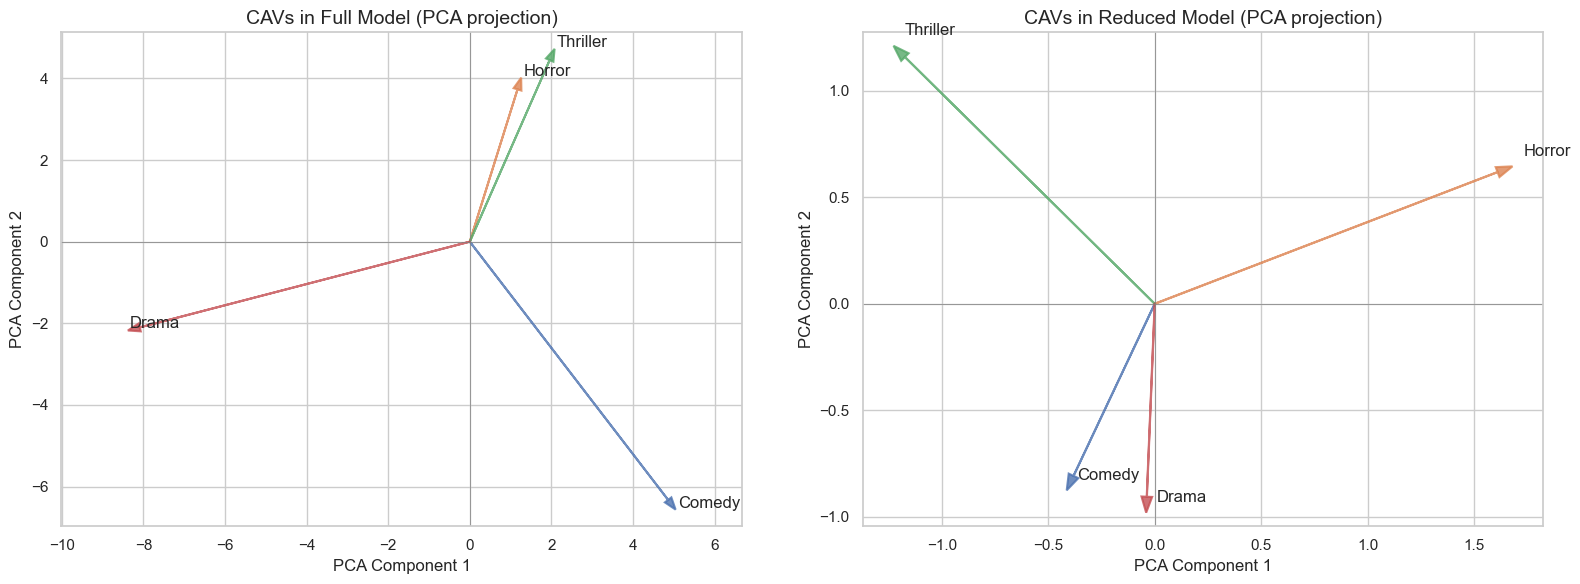

In [32]:
#PCA visualization of CAVs in the reduced model
# Visualizing CAVS

# First, visualize CAVs for the original model
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

# Plot origin
origin = np.array([0, 0])

# Draw arrows from origin to each cav vector
for i, name in enumerate(example_concepts):
    vec = cav_2d[i]
    plt.arrow(origin[0], origin[1], vec[0], vec[1],
              head_width=0.2, length_includes_head=True, color='C'+str(i), alpha=0.8, linewidth=1.5)
    plt.text(vec[0] + 0.05, vec[1] + 0.05, name, fontsize=12)

plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)

plt.title("2D Vector Visualization of CAVs (PCA projection)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()

# Now prepare data for the reduced model
reduced_example_genres = ["Comedy", "Horror", "Thriller", "Drama"]
reduced_example_cavs = {}
reduced_conf_matrices = {}

for genre in reduced_example_genres:
    reduced_CAV = RecommenderCAV(processor, reduced_model)
    reduced_example_cavs[genre] = reduced_CAV.train_cav(genre)
    reduced_conf_matrices[genre] = reduced_CAV.conf_matrix

reduced_cav_vectors = np.array(list(reduced_example_cavs.values()))

reduced_pca = PCA(n_components=2)   
reduced_cav_2d = reduced_pca.fit_transform(reduced_cav_vectors)

# Create a figure with two subplots side by side
plt.figure(figsize=(16, 6))

# First subplot for original model
plt.subplot(1, 2, 1)
sns.set(style="whitegrid")
origin = np.array([0, 0])

for i, name in enumerate(example_concepts):
    vec = cav_2d[i]
    plt.arrow(origin[0], origin[1], vec[0], vec[1],
              head_width=0.2, length_includes_head=True, color='C'+str(i), alpha=0.8, linewidth=1.5)
    plt.text(vec[0] + 0.05, vec[1] + 0.05, name, fontsize=12)

plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.title("CAVs in Full Model (PCA projection)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.axis('equal')

# Second subplot for reduced model
plt.subplot(1, 2, 2)
origin = np.array([0, 0])

for i, genre in enumerate(reduced_example_genres):
    vec = reduced_cav_2d[i]
    plt.arrow(origin[0], origin[1], vec[0], vec[1], 
              head_width=0.05, length_includes_head=True, color='C'+str(i), alpha=0.8, linewidth=1.5)
    plt.text(vec[0] + 0.05, vec[1] + 0.05, genre, fontsize=12)

plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.title("CAVs in Reduced Model (PCA projection)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.axis('equal')

plt.tight_layout()
plt.show()

# Update the confusion matrices variable to use the reduced model results
conf_matrices = reduced_conf_matrices

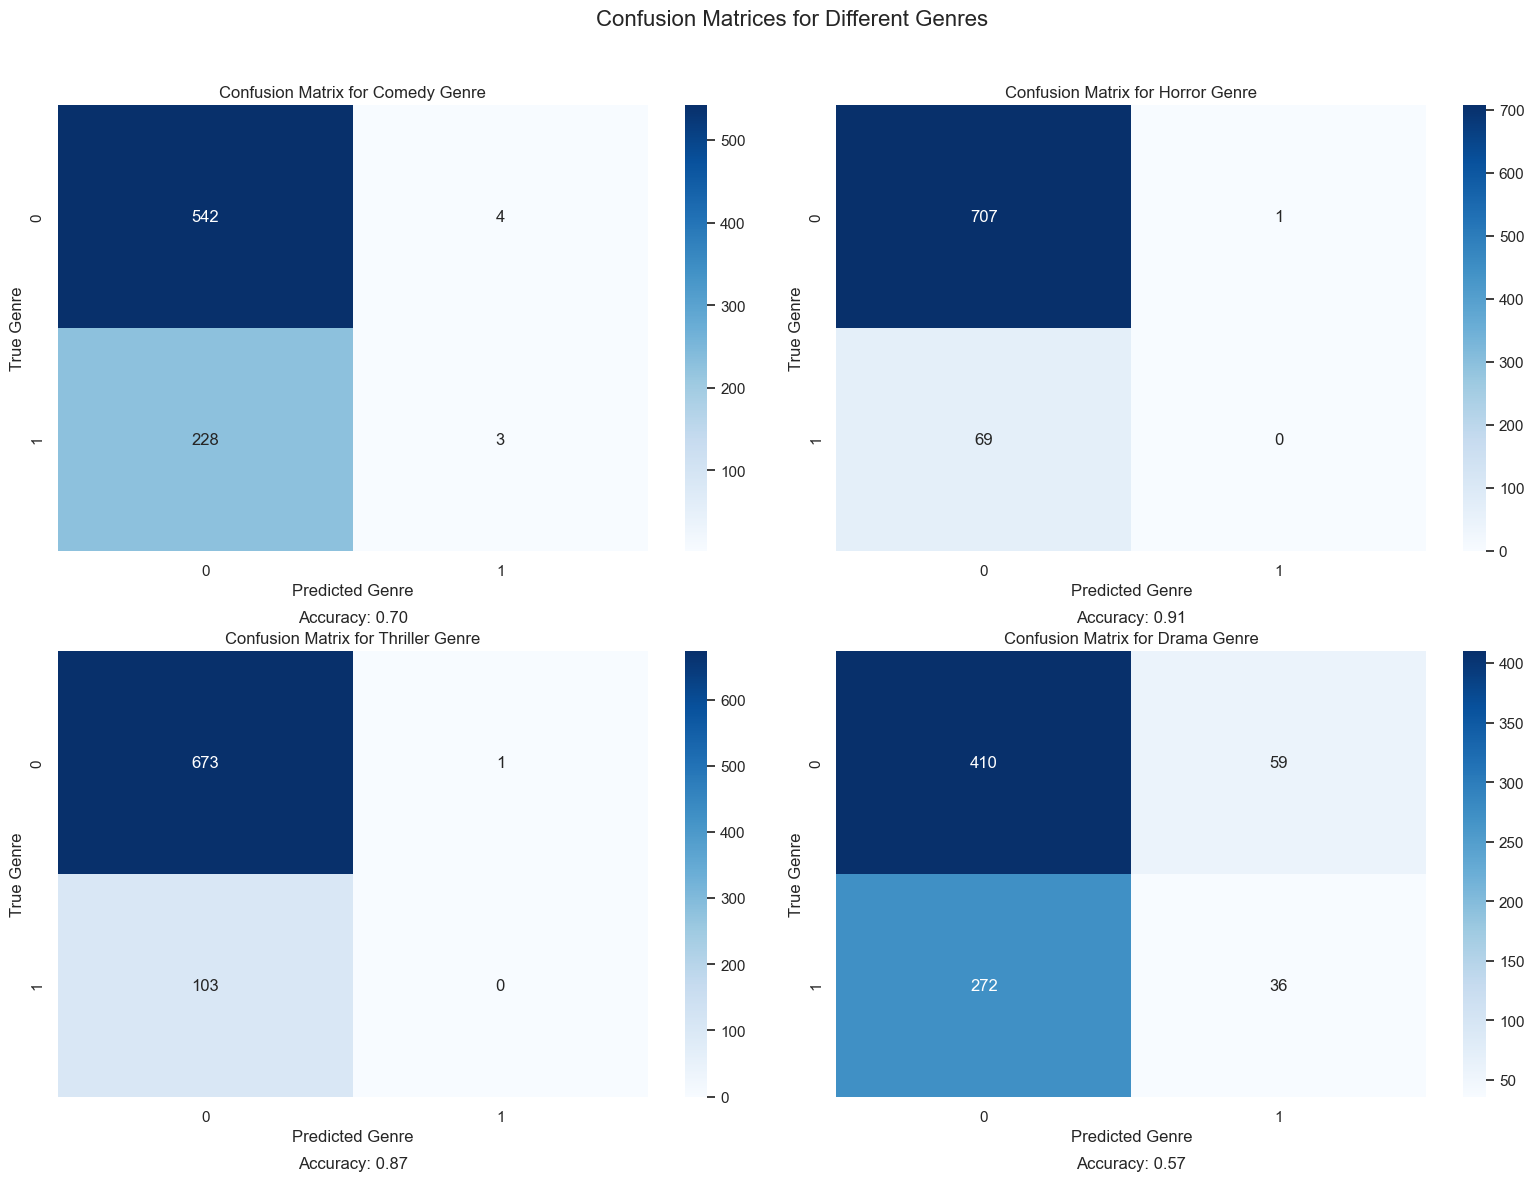

In [33]:
# Create a figure with 2x2 subplots for all four confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Plot each confusion matrix in its own subplot
for i, (genre, matrix) in enumerate(conf_matrices.items()):
    ax = axes[i]
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for {genre} Genre')
    ax.set_xlabel('Predicted Genre')
    ax.set_ylabel('True Genre')
    
    # Add accuracy text
    accuracy = np.trace(matrix) / np.sum(matrix)
    ax.text(0.5, -0.15, f'Accuracy: {accuracy:.2f}', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Confusion Matrices for Different Genres', fontsize=16)
plt.show()

# Genre_oriented recoomendation

In [57]:
print(model.final_user_embedding.shape)
print(model.final_item_embedding.shape)

predicted_ratings = model.final_user_embedding.numpy() @ model.final_item_embedding.numpy().T

torch.Size([6040, 64])
torch.Size([3883, 64])


In [58]:
processor.movies

,item,title,genres,genres_encoded
0,0,Toy Story (1995),Animation|Children's|Comedy,"[1, 11, 4]"
1,1,Jumanji (1995),Adventure|Children's|Fantasy,"[12, 11, 16]"
2,2,Grumpier Old Men (1995),Comedy|Romance,"[4, 13]"
3,3,Waiting to Exhale (1995),Comedy|Drama,"[4, 8]"
4,4,Father of the Bride Part II (1995),Comedy,[4]
...,...,...,...,...
3878,3878,Meet the Parents (2000),Comedy,[4]
3879,3879,Requiem for a Dream (2000),Drama,[8]
3880,3880,Tigerland (2000),Drama,[8]
3881,3881,Two Family House (2000),Drama,[8]


In [59]:
processor.users.iloc[0]

user                          0
gender                        1
age                           1
K-12 student               True
academic/educator         False
artist                    False
clerical/admin            False
college/grad student      False
customer service          False
doctor/health care        False
executive/managerial      False
farmer                    False
homemaker                 False
lawyer                    False
other or not specified    False
programmer                False
retired                   False
sales/marketing           False
scientist                 False
self-employed             False
technician/engineer       False
tradesman/craftsman       False
unemployed                False
writer                    False
Name: 0, dtype: object

In [79]:
from pyperclip import copy

user = 0
user_ratings = predicted_ratings[user, :]
top_k_indices = np.argsort(user_ratings)[::-1][:5]
display(processor.movies.iloc[top_k_indices])
copy(processor.movies.iloc[top_k_indices].to_latex())


,item,title,genres,genres_encoded
2789,2789,American Beauty (1999),Comedy|Drama,"[4, 8]"
2693,2693,"Sixth Sense, The (1999)",Thriller,[2]
589,589,"Silence of the Lambs, The (1991)",Drama|Thriller,"[8, 2]"
2502,2502,"Matrix, The (1999)",Action|Sci-Fi|Thriller,"[17, 10, 2]"
315,315,"Shawshank Redemption, The (1994)",Drama,[8]


In [80]:
all_cavs['Drama'].shape
model.final_user_embedding.numpy()[0].shape

user_0_emd = model.final_user_embedding.numpy()[0]
drame_cav = all_cavs['Drama']
horror_cav = all_cavs['Horror']

gamma = 0.1

adjusted_user_0_emd = user_0_emd + gamma * (horror_cav - user_0_emd)

adjusted_predicted_ratings = adjusted_user_0_emd @ model.final_item_embedding.numpy().T

adjusted_predicted_ratings.shape

adjusted_top_5_indices = np.argsort(adjusted_predicted_ratings)[::-1][:5]

processor.movies.iloc[adjusted_top_5_indices]
copy(processor.movies.iloc[adjusted_top_5_indices].to_latex())


In [62]:
processor.movies.iloc[adjusted_top_5_indices]['title']

2789                               American Beauty (1999)
2693                              Sixth Sense, The (1999)
2502                                   Matrix, The (1999)
3561    House of Exorcism, The (La Casa dell'esorcismo...
589                      Silence of the Lambs, The (1991)
Name: title, dtype: object

In [55]:
all_vectors.shape

(8, 64)

In [56]:
top_5_movie_embeddings.shape

(5, 64)

/var/folders/5z/8hzvmhln5p36t4tdqc9c52z40000gn/T/ipykernel_16872/2297120555.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(all_vecs))  # tab10 supports up to 10 easily distinguishable colors


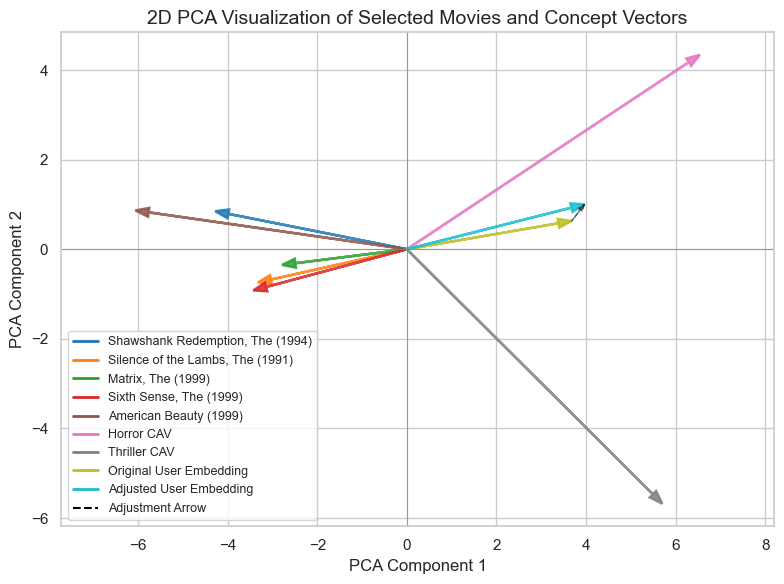

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.cm as cm

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Parameters
NUM_MOVIES_TO_SHOW = 5  # only visualize first N movies for clarity

# Get union and select top-N
union_indices = np.union1d(adjusted_top_5_indices, top_k_indices)
selected_indices = union_indices[:NUM_MOVIES_TO_SHOW]
top_movie_embeddings = model.final_item_embedding.numpy()[selected_indices]

# CAVs and user embeddings
horror_cav = all_cavs['Horror']
thriller_cav = all_cavs['Thriller']

# Combine vectors
all_vectors = np.vstack([
    top_movie_embeddings,
    horror_cav.reshape(1, -1),
    thriller_cav.reshape(1, -1),
    user_0_emd.reshape(1, -1),
    adjusted_user_0_emd.reshape(1, -1)
])

# PCA
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(all_vectors)

# Split
n_movies = len(selected_indices)
reduced_movie_embeddings = reduced_vectors[:n_movies]
reduced_horror_cav = reduced_vectors[n_movies]
reduced_thriller_cav = reduced_vectors[n_movies + 1]
reduced_user_0 = reduced_vectors[n_movies + 2]
reduced_adjusted_user = reduced_vectors[n_movies + 3]

# Labels
all_names = [processor.movies.iloc[idx]['title'] for idx in selected_indices] + \
            ['Horror CAV', 'Thriller CAV', 'Original User Embedding', 'Adjusted User Embedding']
all_vecs = list(reduced_movie_embeddings) + \
           [reduced_horror_cav, reduced_thriller_cav, reduced_user_0, reduced_adjusted_user]

# Use colormap for enough distinct colors
cmap = cm.get_cmap('tab10', len(all_vecs))  # tab10 supports up to 10 easily distinguishable colors

# Plot arrows
origin = np.array([0, 0])
handles = []
for i, (vec, name) in enumerate(zip(all_vecs, all_names)):
    color = cmap(i)
    plt.arrow(origin[0], origin[1], vec[0], vec[1],
              head_width=0.2, length_includes_head=True, color=color, alpha=0.85, linewidth=1.8)
    handles.append(plt.Line2D([0], [0], color=color, lw=2, label=name))

# Adjustment arrow
plt.arrow(reduced_user_0[0], reduced_user_0[1],
          reduced_adjusted_user[0] - reduced_user_0[0],
          reduced_adjusted_user[1] - reduced_user_0[1],
          head_width=0.1, length_includes_head=True,
          color='black', alpha=0.6, linestyle='--')
handles.append(plt.Line2D([0], [0], color='black', linestyle='--', lw=1.5, label='Adjustment Arrow'))

# Axes and legend
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.title("2D PCA Visualization of Selected Movies and Concept Vectors", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.axis('equal')
plt.grid(True)
plt.legend(handles=handles, loc='best', fontsize=9)

# Save figure
plt.tight_layout()
plt.savefig("cav_visualization.pdf")
plt.savefig("cav_visualization.png", dpi=300)
plt.show()
